In [1]:
!pip install -U annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551809 sha256=4602b79f11cd7f139075791b1891e26c060ebba44efe078a5af9fccae2ea7c2a
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [2]:
from annoy import AnnoyIndex
import random

f = 40

t = AnnoyIndex(f, 'angular')
for i in range(1000):
    v = [random.gauss(0, 1) for z in range(f)]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

[0, 493, 209, 629, 805, 939, 431, 217, 55, 460, 33, 237, 403, 569, 572, 726, 887, 857, 794, 869, 694, 262, 747, 778, 394, 52, 119, 969, 101, 328, 412, 392, 175, 339, 912, 932, 641, 682, 933, 68, 789, 507, 994, 866, 505, 664, 2, 839, 129, 702, 49, 519, 423, 841, 516, 197, 147, 611, 678, 930, 361, 984, 409, 697, 309, 54, 360, 943, 39, 45, 679, 495, 898, 908, 385, 581, 290, 785, 62, 212, 435, 443, 515, 381, 76, 728, 594, 711, 660, 484, 498, 489, 482, 595, 165, 536, 341, 784, 956, 184, 434, 598, 749, 271, 419, 10, 596, 61, 779, 872, 100, 662, 875, 247, 162, 183, 233, 335, 770, 284, 74, 453, 666, 990, 350, 764, 772, 977, 156, 976, 565, 810, 801, 13, 297, 112, 500, 291, 816, 373, 993, 792, 185, 196, 540, 853, 859, 141, 462, 363, 879, 142, 856, 973, 826, 972, 709, 827, 873, 684, 383, 125, 675, 800, 652, 198, 634, 895, 513, 58, 892, 238, 876, 231, 440, 962, 877, 558, 407, 804, 720, 338, 476, 103, 276, 571, 414, 766, 743, 362, 372, 449, 485, 81, 24, 29, 608, 344, 404, 987, 757, 614, 695, 268, 6

In [6]:
import numpy as np
import random

class AnnoyNode:
  def __init__(self, normal=None, threshold=None, left=None, right=None, indices=None):
    self.normal = normal
    self.threshold = threshold
    self.left = left
    self.right = right
    self.indices = indices

def build_tree(data, indices, leaf_size=10):
  if len(indices) <= leaf_size:
    return AnnoyNode(indices=indices)

  i1, i2, = random.sample(indices, 2)
  p1 = data[i1]
  p2 = data[i2]

  normal = p1 - p2

  if np.allclose(normal, 0):
    return AnnoyNode(indices=indices)

  midpoint = (p1 + p2) / 2

  threshold = np.dot(normal, midpoint)

  left_indices = []
  right_indices = []

  for idx in indices:
    point = data[idx]
    projection = np.dot(normal, point)

    if projection <= threshold:
      left_indices.append(idx)
    else:
      right_indices.append(idx)

  if len(left_indices) == 0 or len(right_indices) == 0:
    return AnnoyNode(indices=indices)

  left_child = build_tree(data, left_indices, leaf_size)
  right_child = build_tree(data, right_indices, leaf_size)

  return AnnoyNode(
      normal=normal,
      threshold=threshold,
      left=left_child,
      right=right_child
  )

In [7]:
import numpy as np

data = np.array([
    [1, 2],
    [2, 3],
    [3, 1],
    [6, 5],
    [7, 7],
    [8, 6]
])

indices = list(range(len(data)))

tree = build_tree(data, indices, leaf_size=2)

def print_tree(node, depth=0):
    indent = "  " * depth
    if node.indices is not None:
        print(f"{indent}Leaf: {node.indices}")
    else:
        print(f"{indent}Node: w={node.normal}, b={node.threshold:.2f}")
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)

print_tree(tree)


Node: w=[ 1 -2], b=-1.50
  Node: w=[6 5], b=46.50
    Leaf: [0, 1]
    Node: w=[-2 -1], b=-19.50
      Leaf: [4, 5]
      Leaf: [3]
  Leaf: [2]


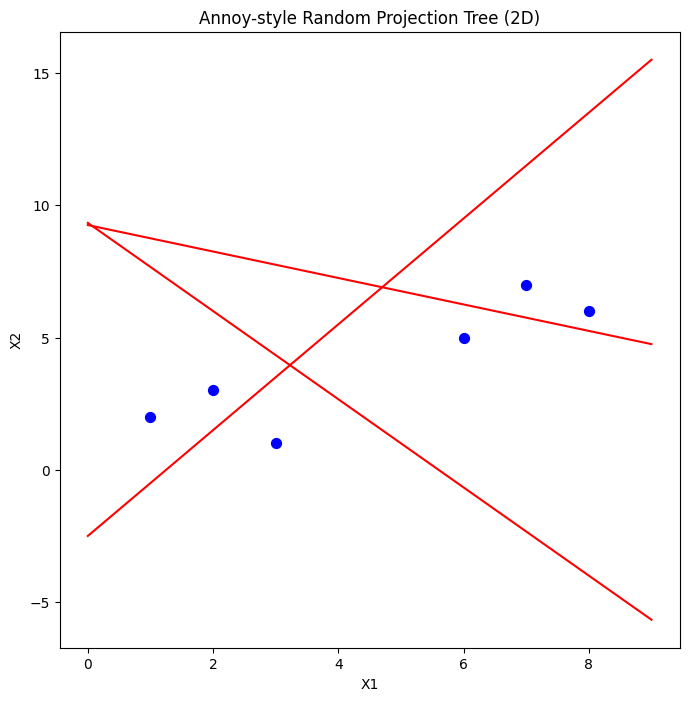

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 2D example dataset
data = np.array([
    [1, 2],
    [2, 3],
    [3, 1],
    [6, 5],
    [7, 7],
    [8, 6]
])
indices = list(range(len(data)))
tree = build_tree(data, indices, leaf_size=2)

def plot_annoy_tree(node, xmin, xmax, ymin, ymax):
    if node is None or node.indices is not None:
        return

    w = node.normal
    b = node.threshold
    if abs(w[1]) > 1e-6:
        y1 = (b - w[0]*xmin)/w[1]
        y2 = (b - w[0]*xmax)/w[1]
        plt.plot([xmin, xmax], [y1, y2], 'r-')
    else:
        x = b / w[0]
        plt.plot([x, x], [ymin, ymax], 'r-')
    plot_annoy_tree(node.left, xmin, xmax, ymin, ymax)
    plot_annoy_tree(node.right, xmin, xmax, ymin, ymax)

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], c='blue', s=50)
plot_annoy_tree(tree, data[:, 0].min()-1, data[:, 0].max()+1,
                data[:, 1].min()-1, data[:, 1].max()+1)

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Annoy-style Random Projection Tree (2D)")
plt.show()
